# Problem Statement
The task involves constructing a multiple linear regression model to predict the demand for shared bikes using the provided dataset. The dataset contains various independent variables related to weather, time, and other factors that might influence bike demand. The goal is to understand the significant variables affecting bike demand and create a model to predict it accurately.
## Business Goal:
* Predict the demand for shared bikes based on various independent variables.
* Assist management in understanding demand dynamics for strategic planning.
## Data Preparation:
* Some numeric columns (e.g., 'weathersit', 'season') with values 1, 2, 3, 4 need conversion into categorical string values as these numeric values do not imply any order.
* The 'year' column representing the years 2018 and 2019 might appear insignificant but might hold predictive value considering the increasing bike demand annually.
Model Building:
* The target variable ('cnt') represents the total number of bike rentals (casual + registered users).
* Utilize 'cnt' as the target variable and build a multiple linear regression model using other independent variables.
Model Evaluation:
* Assess model performance using the R-squared score on the test set to gauge how well the model predicts bike demand.
* Utilize the provided code snippet to calculate the R-squared score on the test set.

## Data Understanding preparation and EDA

In [269]:
from matplotlib import rcParams
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.feature_selection as feature_selection
import sklearn.pipeline as pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.filterwarnings('ignore')
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27



Dataset characteristics
day.csv have the following fields:	
- instant: record index
- date : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- year : year (0: 2018, 1:2019)
- month : month ( 1 to 12)
- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weather_code : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- humidity: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- count: count of total rental bikes including both casual and registered

In [270]:

filename = "day.csv"

df = pd.read_csv(filename)
df.head(7)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
6,7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510


In [271]:

# rename the variables to something more meaningful for easier understanding

column_names = {'dteday': 'date',
                'yr': 'year',
                'mnth': 'month',
                'weathersit': 'weather_code',
                'hum': 'humidity',
                'cnt': 'count',
                'atemp': 'apparent_temperature'}

df.rename(columns=column_names, inplace=True)
df

,instant,date,season,year,month,holiday,weekday,workingday,weather_code,temp,apparent_temperature,humidity,windspeed,casual,registered,count
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


In [272]:
# shape of the dataset
df.shape

(730, 16)


* 730 records and 16 variables

In [273]:
# info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   instant               730 non-null    int64  
 1   date                  730 non-null    object 
 2   season                730 non-null    int64  
 3   year                  730 non-null    int64  
 4   month                 730 non-null    int64  
 5   holiday               730 non-null    int64  
 6   weekday               730 non-null    int64  
 7   workingday            730 non-null    int64  
 8   weather_code          730 non-null    int64  
 9   temp                  730 non-null    float64
 10  apparent_temperature  730 non-null    float64
 11  humidity              730 non-null    float64
 12  windspeed             730 non-null    float64
 13  casual                730 non-null    int64  
 14  registered            730 non-null    int64  
 15  count                 7


* Every field is numeric except date.
* date is in object form and needs to be converted to datetime format.

In [274]:
# descriptive statistics
df.describe()

,instant,season,year,month,holiday,weekday,workingday,weather_code,temp,apparent_temperature,humidity,windspeed,casual,registered,count
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [275]:

# number of numerical variables
len(df.describe().columns)

15

* There are 15 numerical variables.
* But some of them need to be converted to categorical variables.


* count is the target variable. count of total rental bikes including both casual and registered
* instant is the record index and it is irrelevant to the target variable. 


In [276]:

df1 = df.copy()

# covert date to datetime format
df1['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

df1.head()

,instant,date,season,year,month,holiday,weekday,workingday,weather_code,temp,apparent_temperature,humidity,windspeed,casual,registered,count
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [277]:
# check the weekdays
df2 = df1[['date', 'weekday', 'workingday', 'holiday', 'year', 'month']]
df2['weekdayactual'] = df2.date.dt.weekday
df2

df2.head(14)
# weekday is not actually matching with the date.

,date,weekday,workingday,holiday,year,month,weekdayactual
0,2018-01-01,6,0,0,0,1,0
1,2018-01-02,0,0,0,0,1,1
2,2018-01-03,1,1,0,0,1,2
3,2018-01-04,2,1,0,0,1,3
4,2018-01-05,3,1,0,0,1,4
5,2018-01-06,4,1,0,0,1,5
6,2018-01-07,5,1,0,0,1,6
7,2018-01-08,6,0,0,0,1,0
8,2018-01-09,0,0,0,0,1,1
9,2018-01-10,1,1,0,0,1,2


In [278]:

# check the correlation between the count with casual users and registered users
print(df1["registered"].corr(df1["count"]))
print(df1["casual"].corr(df1["count"]))

df3 = df1[["registered", "casual", "count"]]
df3["reg_casual_sum"] = df3["registered"] + df3["casual"]

# check if the sum of registered and casual users is equal to the count
(df3['reg_casual_sum'] == df3['count']).all()

0.9454106118483712
0.6721234097443969


True

In [279]:
column = 'date'
# number of unique values in date column
print(df1[column].nunique())

# minimum date and maximum date
print(df1[column].min(), df1[column].max())

730
2018-01-01 00:00:00 2019-12-31 00:00:00


* date is converted to datetime format.
* in the data mapping used is with sunday as 0, weekday in pandas is with monday as 0. After considering this difference weekday still does not match
* 2018 January 1 is a monday. But in the data it is a Saturday.
* I strongly feel that the data is not from 2018 2019 since the weekdays are not matching with the dates. But this will not change the analysis.
* Drop the instant column since it is irrelevant to the target variable.
* count is the sum of registered and casual users. So we must drop these two columns, otherwise the model will not have any practical use.
* drop the date column since we have the year, month, weekday, holiday, workingday columns.

In [280]:

columns_to_drop = ['instant', 'registered', 'casual', 'date']
# drop the instant column
df1.drop(columns_to_drop, inplace=True, axis=1)

df1.head()

,season,year,month,holiday,weekday,workingday,weather_code,temp,apparent_temperature,humidity,windspeed,count
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [281]:

# a nicer view of the desriptive statistics
df1.describe().applymap('{:,.2f}'.format)

,season,year,month,holiday,weekday,workingday,weather_code,temp,apparent_temperature,humidity,windspeed,count
count,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00
mean,2.50,0.50,6.53,0.03,3.00,0.68,1.39,20.32,23.73,62.77,12.76,"4,508.01"
std,1.11,0.50,3.45,0.17,2.01,0.47,0.54,7.51,8.15,14.24,5.20,"1,936.01"
min,1.00,0.00,1.00,0.00,0.00,0.00,1.00,2.42,3.95,0.00,1.50,22.00
25%,2.00,0.00,4.00,0.00,1.00,0.00,1.00,13.81,16.89,52.00,9.04,"3,169.75"
50%,3.00,0.50,7.00,0.00,3.00,1.00,1.00,20.47,24.37,62.62,12.13,"4,548.50"
75%,3.00,1.00,10.00,0.00,5.00,1.00,2.00,26.88,30.45,72.99,15.63,"5,966.00"
max,4.00,1.00,12.00,1.00,6.00,1.00,3.00,35.33,42.04,97.25,34.00,"8,714.00"


In [282]:

# check for missing values
df1.isnull().sum()

season                  0
year                    0
month                   0
holiday                 0
weekday                 0
workingday              0
weather_code            0
temp                    0
apparent_temperature    0
humidity                0
windspeed               0
count                   0
dtype: int64


* There are no missing values in the dataset.

In [283]:

# find categorical variables
categorical_variables = []
for column in df1.columns:
    if len(df1[column].value_counts()) < 25:
        # print(column)
        categorical_variables.append(column)
        
categorical_variables.sort()
print(categorical_variables, len(categorical_variables))

['holiday', 'month', 'season', 'weather_code', 'weekday', 'workingday', 'year'] 7



* There are 7 categorical variables.

In [284]:

# find numerical variables

numerical_variables = list(set(df1.columns) - set(categorical_variables))
numerical_variables.sort()
numerical_variables

['apparent_temperature', 'count', 'humidity', 'temp', 'windspeed']

In [285]:

for categorical_variable in categorical_variables:
    display(df1[categorical_variable].value_counts())

0    709
1     21
Name: holiday, dtype: int64

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: month, dtype: int64

3    188
2    184
1    180
4    178
Name: season, dtype: int64

1    463
2    246
3     21
Name: weather_code, dtype: int64

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64

1    499
0    231
Name: workingday, dtype: int64

0    365
1    365
Name: year, dtype: int64

* There are 4 seasons. 
  1. spring
  2. summer
  3. fall
  4. winter
* There are 2 years.
  0. 2018
  1. 2019
* There are 12 months. 1 to 12
* There are 2 values in holiday.
   0. not a holiday
   1. holiday
* There are 7 values in weekday. 0 to 6
* There are 2 values in workingday.
0. weekend or holiday
1. not weekend or holiday
* There are 4 values in weather_code.
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* our dataset does not contain the value 4

In [286]:

categorical_variables

['holiday', 'month', 'season', 'weather_code', 'weekday', 'workingday', 'year']

In [287]:

# Define mapping dictionary
season_mapping = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}

# Map 'season' column to new categories using map()
df1['season'] = df1['season'].map(season_mapping)

# Define mapping dictionary for 'year' column
year_mapping = {0: 2018, 1: 2019}

# Map 'year' column to new year labels using map()
df1['year'] = df1['year'].map(year_mapping)


# Dictionary mapping numeric months to their names
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Map 'month' column to month names using map()
df1['month'] = df1['month'].map(month_mapping)

# Dictionary mapping binary holiday indicator to labels
holiday_mapping = {0: 'Not a Holiday', 1: 'Holiday'}

# Map 'holiday' column to labels using map()
df1['holiday'] = df1['holiday'].map(holiday_mapping)

# Dictionary mapping numeric weekdays to their names with Sunday as 0
weekday_mapping = {
    0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 
    3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'
}

# Map 'weekday' column to weekday names using map()
df1['weekday'] = df1['weekday'].map(weekday_mapping)

# Dictionary mapping binary working day indicator to labels
working_day_mapping = {0: 'Not a Working Day', 1: 'Working Day'}

# Map 'working_day' column to labels using map()
df1['workingday'] = df1['workingday'].map(working_day_mapping)

# Dictionary mapping weather codes to shortened categories
shortened_weather_mapping = {
    1: 'Clear/Few Clouds',
    2: 'Mist/Cloudy',
    3: 'Light Snow/Rain',
    4: 'Heavy Rain/Snow/Fog'
}

# Map 'weather_code' column to shortened categories using map()
df1['weather_code'] = df1['weather_code'].map(shortened_weather_mapping)

In [288]:
len(df1.columns)

12

In [289]:

# convert categorical variables to categorical type
for categorical_variable in categorical_variables:
    df1[categorical_variable] = pd.Categorical(df1[categorical_variable])

In [290]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   season                730 non-null    category
 1   year                  730 non-null    category
 2   month                 730 non-null    category
 3   holiday               730 non-null    category
 4   weekday               730 non-null    category
 5   workingday            730 non-null    category
 6   weather_code          730 non-null    category
 7   temp                  730 non-null    float64 
 8   apparent_temperature  730 non-null    float64 
 9   humidity              730 non-null    float64 
 10  windspeed             730 non-null    float64 
 11  count                 730 non-null    int64   
dtypes: category(7), float64(4), int64(1)
memory usage: 35.1 KB



# 2. Visualising Data 
**Understanding the data**
## Visualising Numerical Data

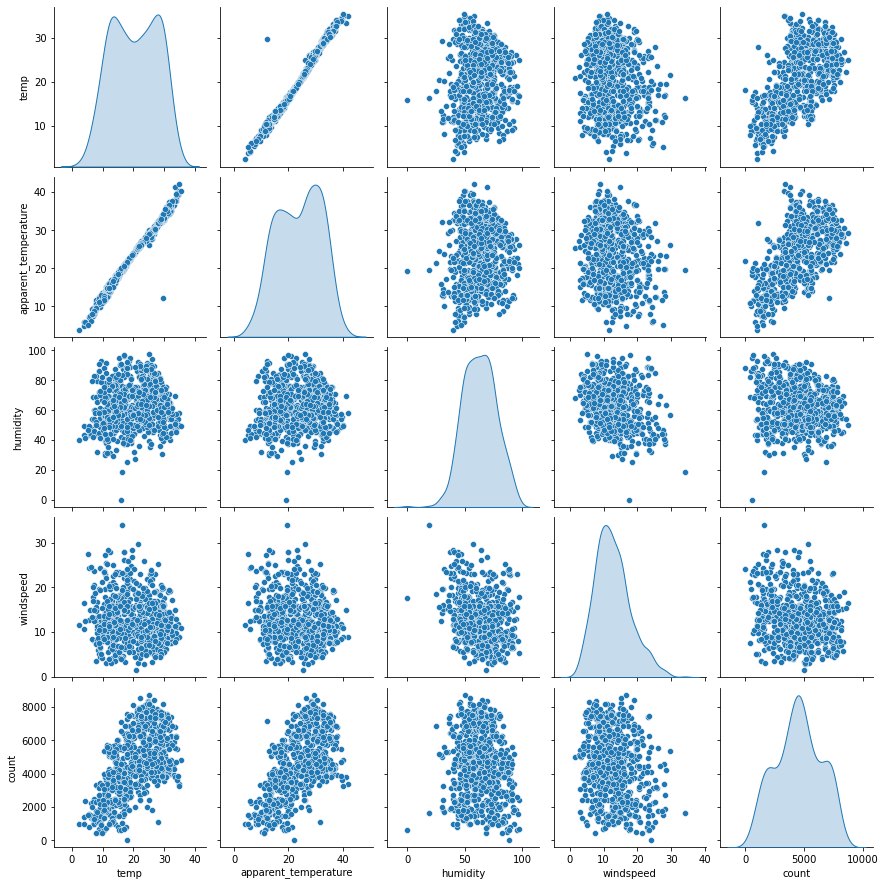

In [291]:

sns.pairplot(df1, diag_kind='kde')

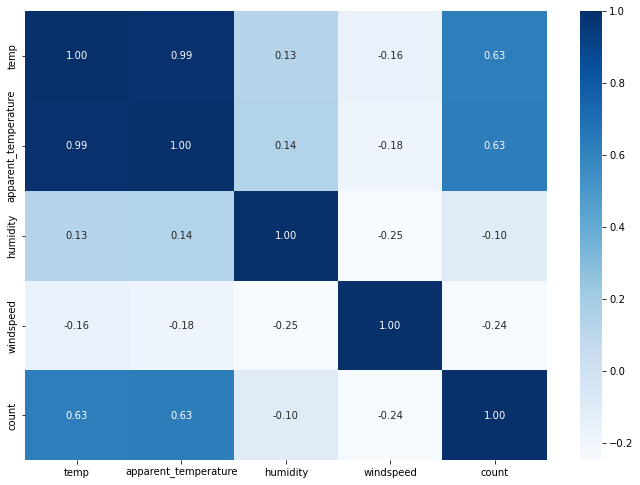

In [292]:

# heatmap of correlation matrix
sns.heatmap(df1.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.show()


## Visualising Categorical Data

In [293]:
categorical_variables

['holiday', 'month', 'season', 'weather_code', 'weekday', 'workingday', 'year']

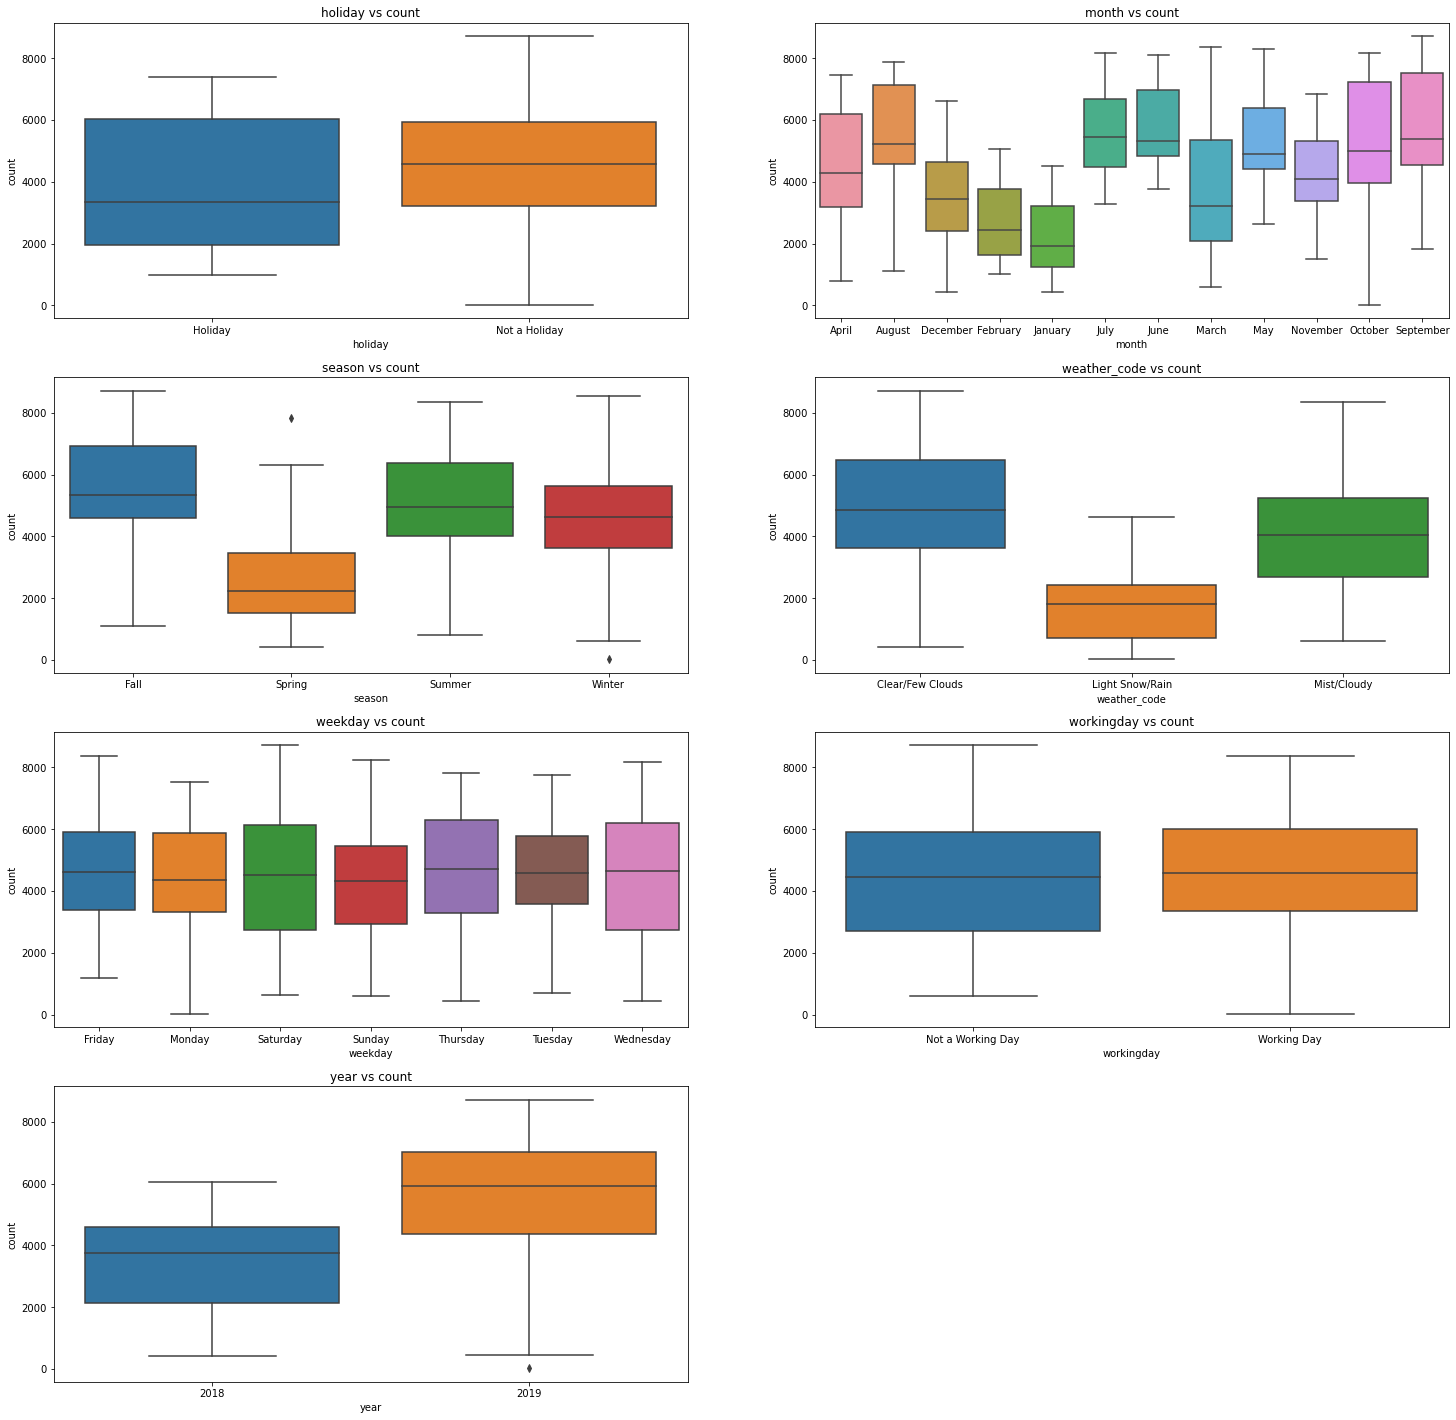

In [294]:

plt.figure(figsize=(25, 25))

for k in range(1, 8):
    plt.subplot(4, 2, k)
    sns.boxplot(x=categorical_variables[k-1], y='count', data=df1)
    plt.title(categorical_variables[k-1] + ' vs count')
plt.show()

holiday
Holiday          3735.00000
Not a Holiday    4530.90268
Name: count, dtype: float64

month
January      2176.338710
February     2669.964286
December     3403.806452
March        3692.258065
November     4247.183333
April        4484.900000
October      5199.225806
May          5349.774194
July         5563.677419
August       5664.419355
September    5766.516667
June         5772.366667
Name: count, dtype: float64

season
Spring    2608.411111
Winter    4728.162921
Summer    4992.331522
Fall      5644.303191
Name: count, dtype: float64

weather_code
Light Snow/Rain     1803.285714
Mist/Cloudy         4044.813008
Clear/Few Clouds    4876.786177
Name: count, dtype: float64

weekday
Sunday       4228.828571
Monday       4338.123810
Tuesday      4510.663462
Saturday     4550.542857
Wednesday    4574.893204
Thursday     4667.259615
Friday       4690.288462
Name: count, dtype: float64

workingday
Not a Working Day    4330.168831
Working Day          4590.332665
Name: count, dtype: float64

year
2018    3405.761644
2019    5610.252055
Name: count, dtype: float64

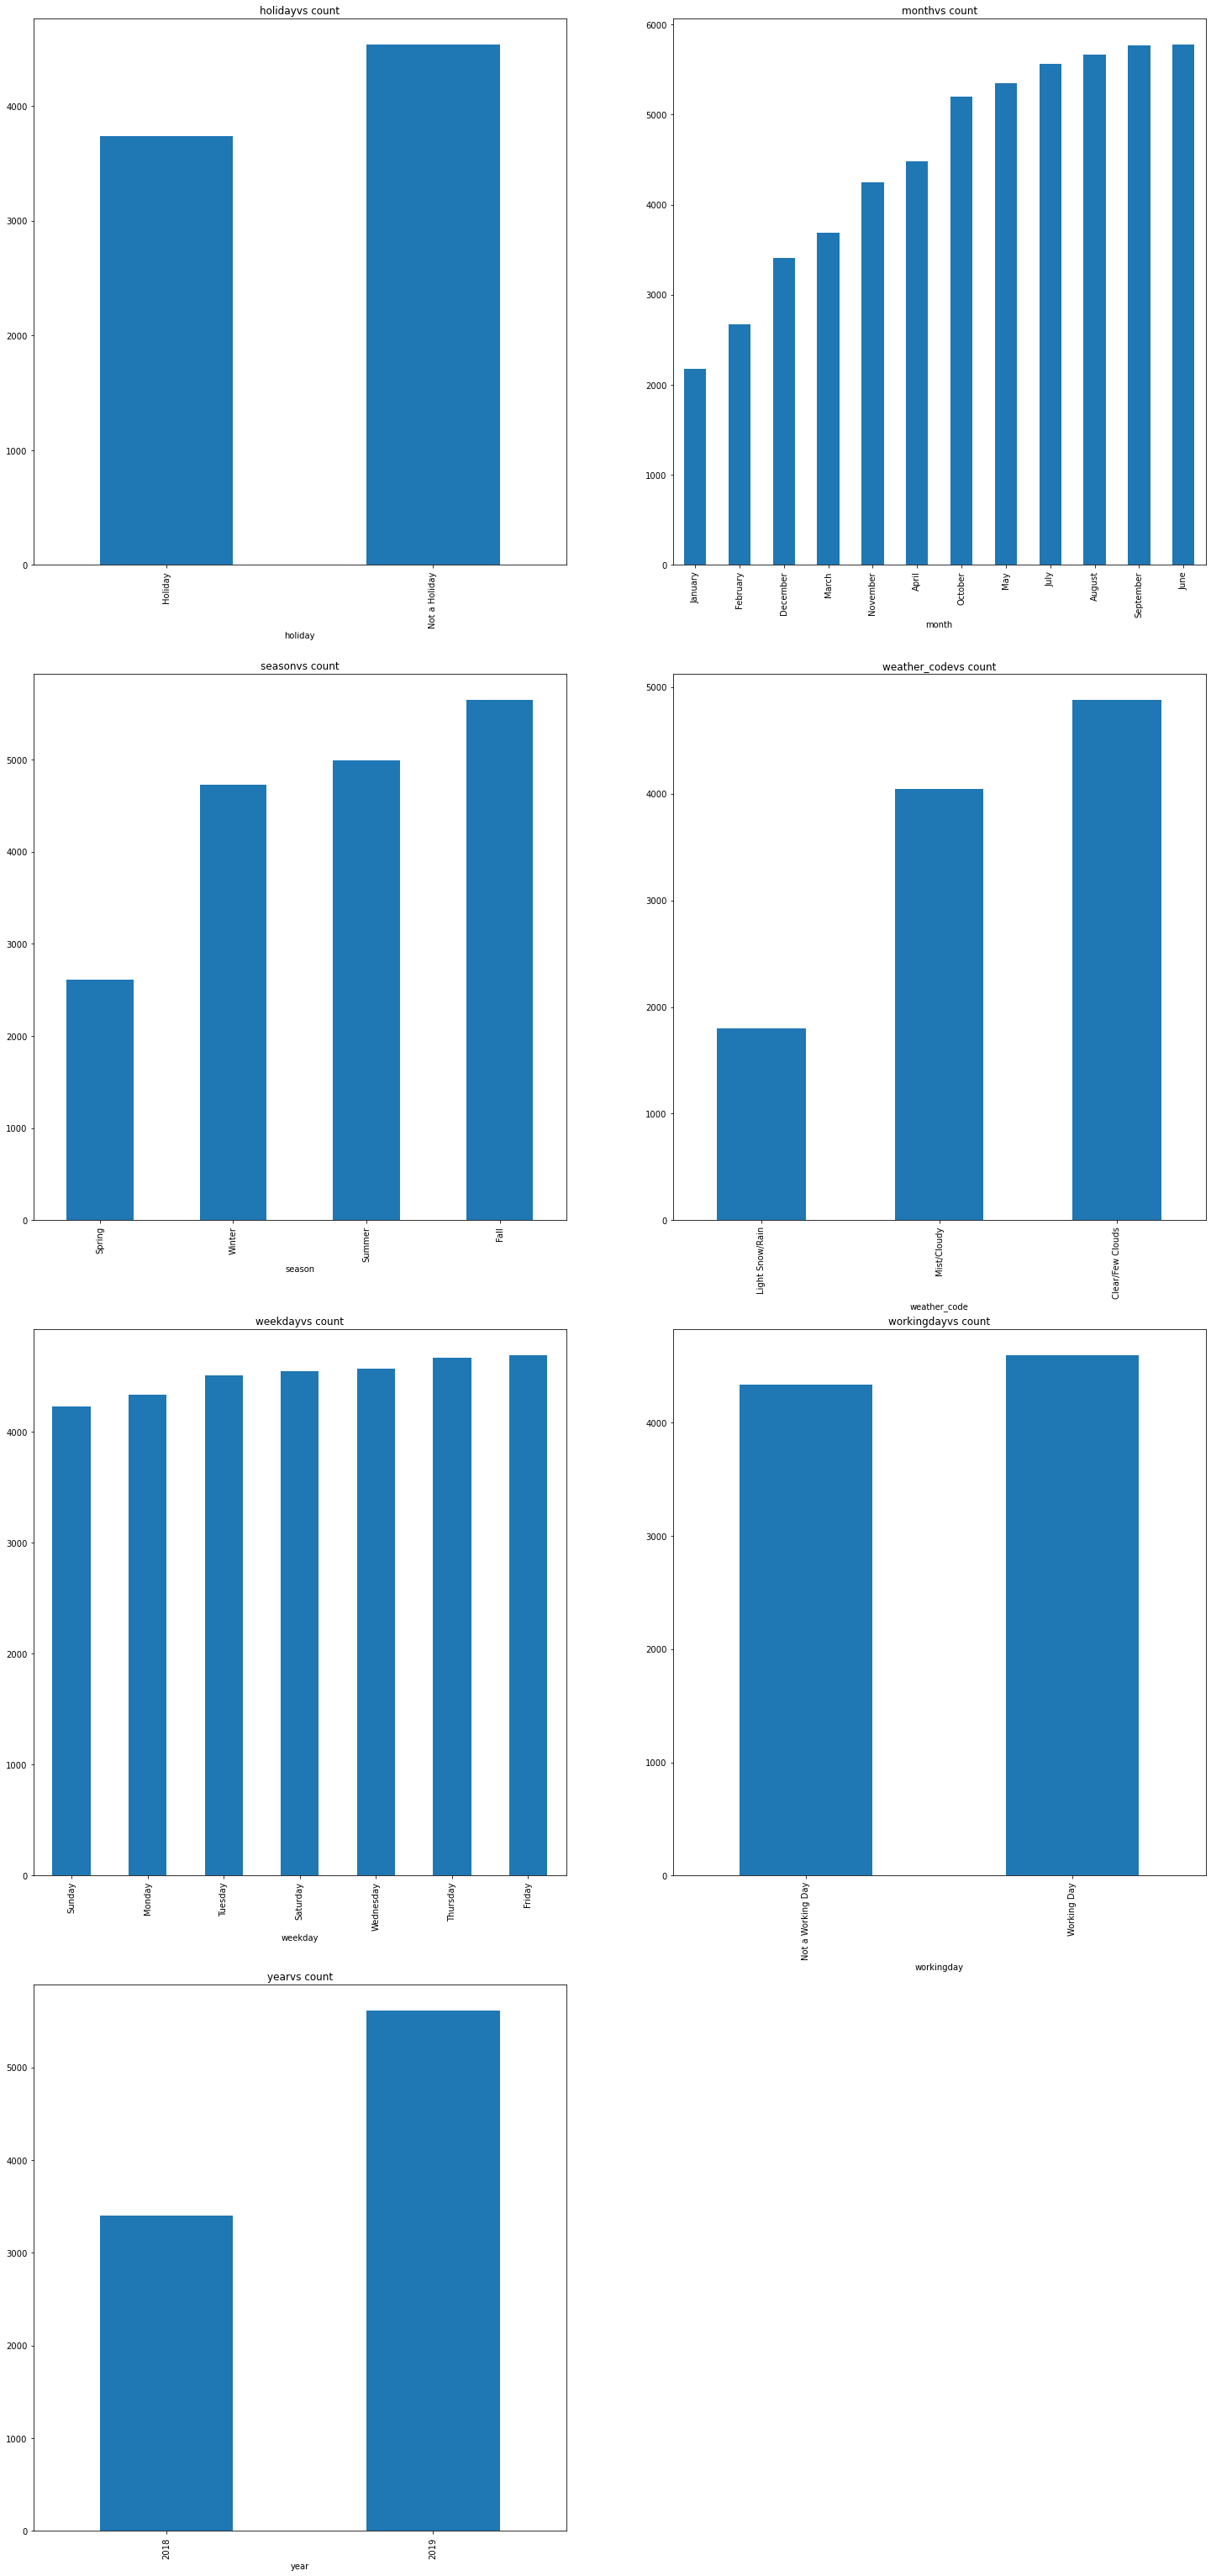

In [295]:
plt.figure(figsize=(25, 55))
for k in range(1, 8):
    plt.subplot(4, 2, k)
    df_count = df1.groupby(categorical_variables[k-1])['count'].mean().sort_values()
    display(df_count)
    df_count.plot.bar()
    plt.title(categorical_variables[k-1] + 'vs count')
    
plt.show()


* Count is higher when it is not a holiday
* Count is higher in May, July, August, September, June in that order. We have good demand starting from april till September. Low demand on October, November, December, January, February.
* Summer and Fall has higher demand than Spring and Winter. Spring has the lowest demand.
* clear whether has higher demand than misty weather and rainy weather
* Demand is the least on sundays.
* Demand is more on working days
* 2019 has higher demand than 2018.


# 3. Data Preparation
* Create dummy variables for all categorical variables.

In [296]:

# create dummy variables for all categorical variables
dummies = []
for categorical_variable in categorical_variables:
    dummy = pd.get_dummies(df1[categorical_variable], drop_first=True)
    dummies.append(dummy)
    
df1.drop(categorical_variables, axis=1, inplace=True)
df1 = pd.concat([df1] + dummies, axis=1)

df1.head()

,temp,apparent_temperature,humidity,windspeed,count,Not a Holiday,August,December,February,January,...,Light Snow/Rain,Mist/Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Working Day,2019
0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
1,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
2,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0


In [297]:
np.random.seed(0)
df_train, df_test = train_test_split(df1, train_size = 0.7, test_size = 0.3, random_state = 100)

In [298]:


numerical_variables

['apparent_temperature', 'count', 'humidity', 'temp', 'windspeed']

In [299]:
# Apply scaler() to all numerical variables
scaler = MinMaxScaler()
df_train[numerical_variables] = scaler.fit_transform(df_train[numerical_variables])

In [300]:

df_train.head()

,temp,apparent_temperature,humidity,windspeed,count,Not a Holiday,August,December,February,January,...,Light Snow/Rain,Mist/Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Working Day,2019
653,0.509887,0.501133,0.575354,0.300794,0.864243,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
576,0.815169,0.766351,0.725633,0.264686,0.827658,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
426,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
728,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
482,0.395666,0.391735,0.504508,0.188475,0.482973,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


In [301]:

df_train.describe()

,temp,apparent_temperature,humidity,windspeed,count,Not a Holiday,August,December,February,January,...,Light Snow/Rain,Mist/Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Working Day,2019
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.537262,0.512989,0.650369,0.320768,0.513620,0.974510,0.096078,0.084314,0.066667,0.088235,...,0.029412,0.343137,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.676471,0.507843
std,0.225844,0.212385,0.145882,0.169797,0.224593,0.157763,0.294988,0.278131,0.249689,0.283915,...,0.169124,0.475223,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.468282,0.500429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179,0.356420,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.540519,0.526811,0.653714,0.296763,0.518638,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.735215,0.688457,0.754830,0.414447,0.684710,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [302]:

df_train[numerical_variables].describe()

,apparent_temperature,count,humidity,temp,windspeed
count,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.512989,0.513620,0.650369,0.537262,0.320768
std,0.212385,0.224593,0.145882,0.225844,0.169797
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.332086,0.356420,0.538643,0.339853,0.199179
50%,0.526811,0.518638,0.653714,0.540519,0.296763
75%,0.688457,0.684710,0.754830,0.735215,0.414447
max,1.000000,1.000000,1.000000,1.000000,1.000000


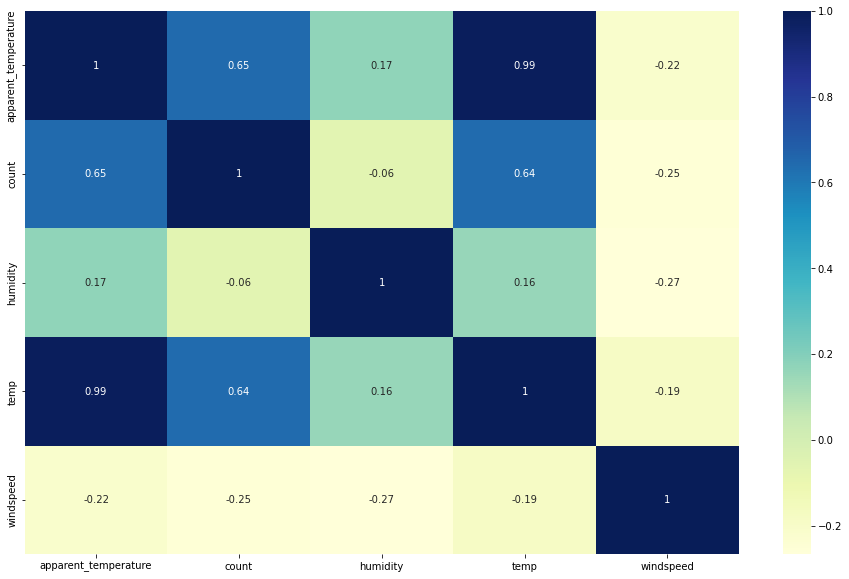

In [303]:
# checking the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (16, 10))
sns.heatmap(df_train[numerical_variables].corr(), annot = True, cmap="YlGnBu")
plt.show()


* apparent_temparature is highly correlated with count

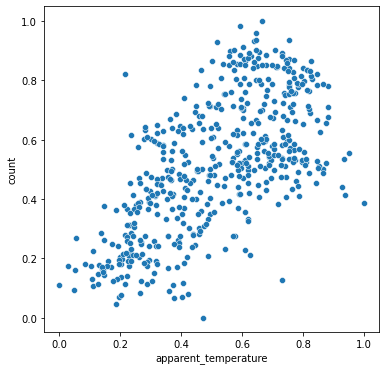

In [304]:

plt.figure(figsize=[6,6])
sns.scatterplot(data=df_train, x="apparent_temperature", y="count")
plt.show()


### Dividing into X and Y sets for the model building

In [305]:

# y_train = df_train.pop("count")
# X_train = df_train

y_train = df_train["count"]
X_train = df_train.drop(["count"], axis=1)

In [306]:

len(X_train.columns)

29

In [307]:

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [308]:

rfe_df = pd.DataFrame({"column": X_train.columns,
              "support": rfe.support_,
              "ranking": rfe.ranking_})

rfe_df.sort_values(by="ranking", inplace=True)

rfe_df

,column,support,ranking
0,temp,True,1
22,Saturday,True,1
20,Mist/Cloudy,True,1
19,Light Snow/Rain,True,1
18,Winter,True,1
17,Summer,True,1
16,Spring,True,1
15,September,True,1
27,Working Day,True,1
28,2019,True,1


In [309]:

selected_columns = X_train.columns[rfe.support_]
selected_columns

# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[selected_columns]
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.6
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          2.31e-191
Time:                        20:38:22   Log-Likelihood:                 519.88
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     494   BIC:                            -940.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1925      0.042     

In [310]:

vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,116.69
8,Spring,5.08
1,temp,3.89
10,Winter,3.60
9,Summer,2.64
2,humidity,1.92
14,Working Day,1.88
13,Saturday,1.78
5,January,1.57
12,Mist/Cloudy,1.57


In [311]:

y_train_count = lm.predict(X_train_rfe)

Text(0.5, 0, 'Errors')

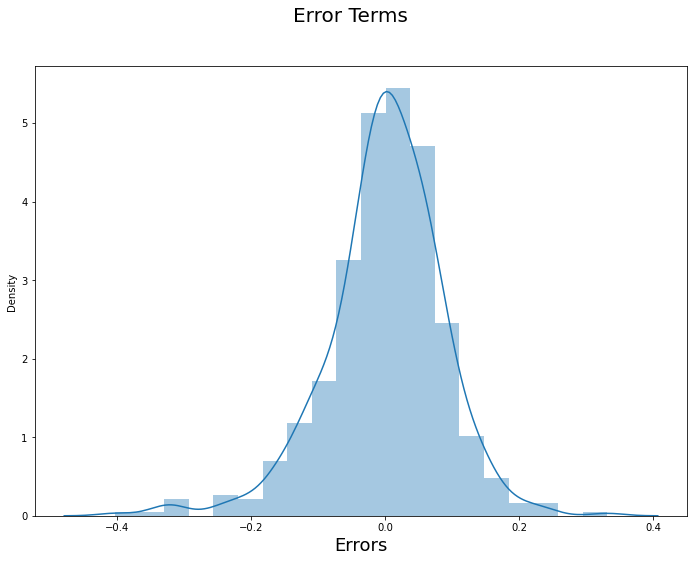

In [312]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_count), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

##

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


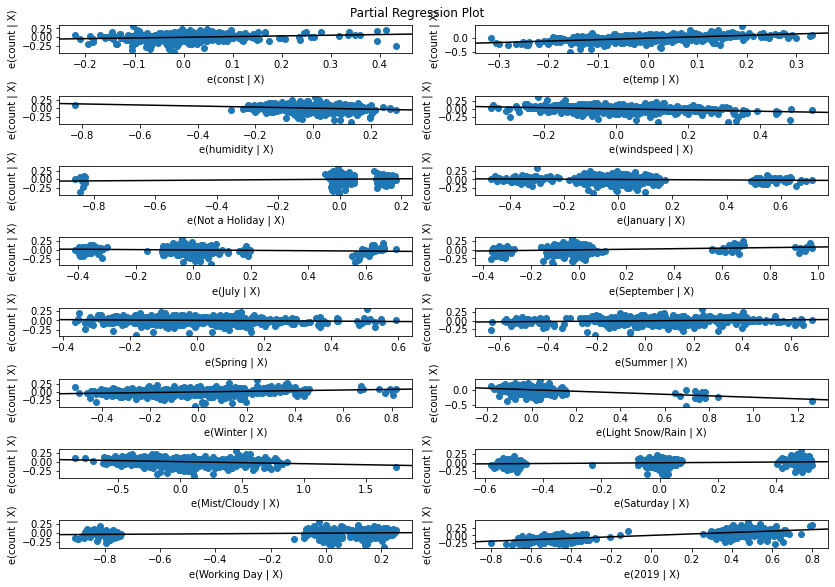

In [313]:
# 1. Linearity Assumption (Using Partial Residual Plots)
sm.graphics.plot_partregress_grid(lm)
plt.show()

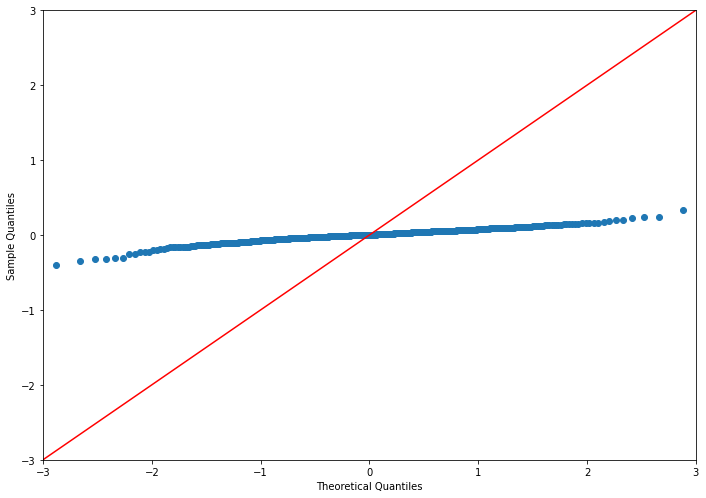

In [314]:

# 2. Normality of Residuals (QQ Plot)
residuals = lm.resid
fig = sm.graphics.qqplot(residuals, line='45')
plt.show()

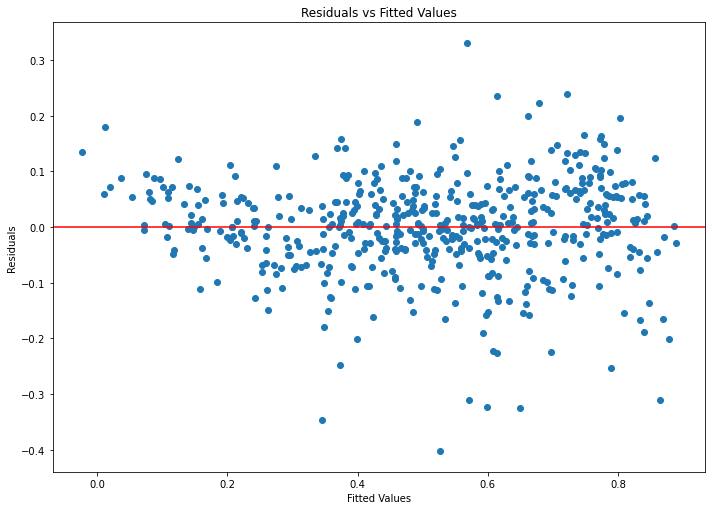

In [315]:

# 3. Homoscedasticity (Residuals vs Fitted Values Plot)
plt.scatter(lm.fittedvalues, lm.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [316]:
# 4. Independence of Residuals (Durbin-Watson Statistic)

durbinWatson = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {durbinWatson}")

Durbin-Watson Statistic: 2.070666575997336


In [317]:


df_test[numerical_variables] = scaler.transform(df_test[numerical_variables])

y_test = df_test["count"]
X_test = df_test.drop(["count"], axis=1)

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[selected_columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [318]:
# Making predictions
y_pred = lm.predict(X_test_new)

Text(0, 0.5, 'y_pred')

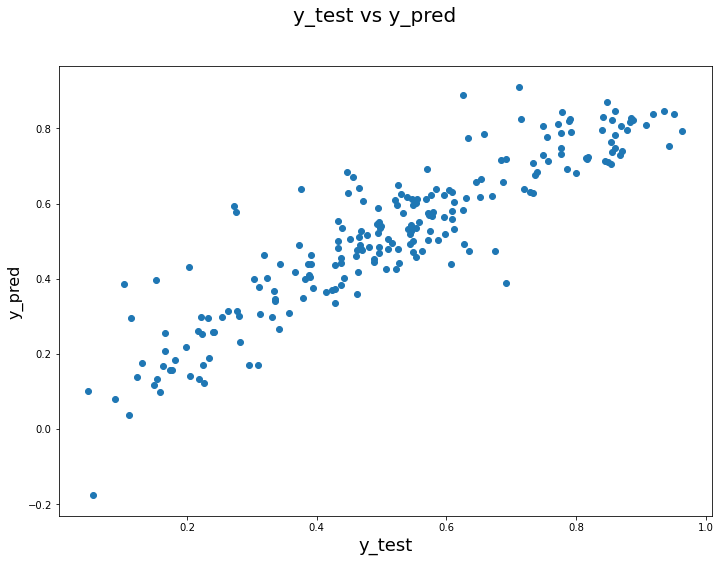

In [319]:

# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)

In [320]:

print("plotting y_test and y_pred to understand the spread.")

plotting y_test and y_pred to understand the spread.


In [321]:
lm.params[lm.params.abs().sort_values().index]

January           -0.034326
Working Day        0.043521
Summer             0.049660
Spring            -0.050806
July              -0.053193
Saturday           0.053721
Mist/Cloudy       -0.057824
Not a Holiday      0.058529
September          0.081186
Winter             0.094426
humidity          -0.154716
windspeed         -0.185956
const              0.192512
2019               0.230502
Light Snow/Rain   -0.248777
temp               0.509836
dtype: float64